In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_1 = pd.read_csv('data (2).csv')
data_2 = pd.read_csv('data_2genre.csv')

data = pd.concat([data_1, data_2])

In [4]:
data.head(5)

,filename,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
1,blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
2,blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
3,blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
4,blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


In [5]:
data['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
1            100
2            100
Name: label, dtype: int64

In [6]:
data['label'] = data['label'].replace(to_replace={1: 'pop', 2: 'classical'})

In [7]:
data['label'].value_counts()

classical    200
pop          200
blues        100
country      100
disco        100
hiphop       100
jazz         100
metal        100
reggae       100
rock         100
Name: label, dtype: int64

Text(0, 0.5, 'Mean Tempo')

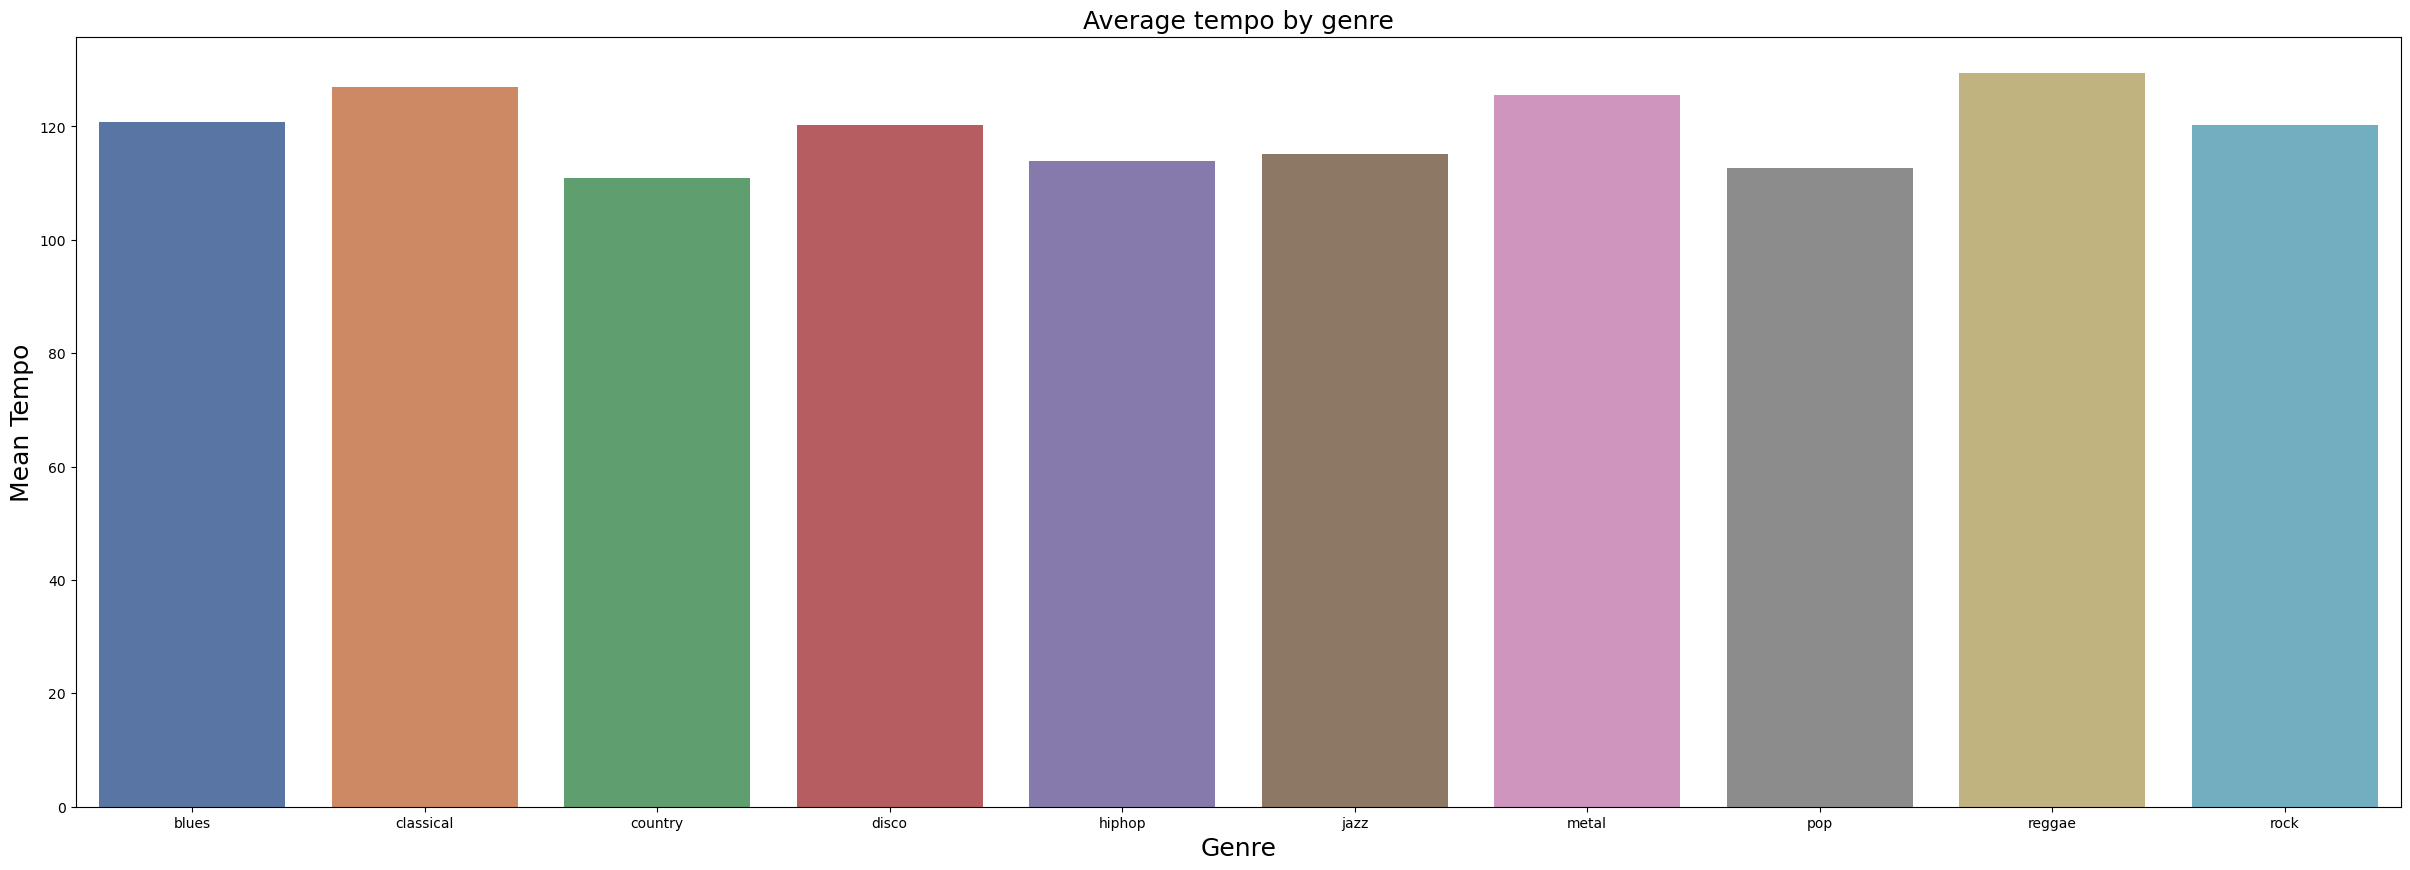

In [9]:
plt.figure(figsize=(30,10))

genres = data['label'].unique()

tempos = [ data[data['label']==x].tempo.mean() for x in genres ]

sns.barplot(x=genres, y=tempos, palette="deep")

plt.title("Average tempo by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Tempo', fontsize = 18)

In [11]:
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, GridSearchCV

data = data.drop('filename', axis=1)

X = data.loc[:, data.columns != 'label']
y = data['label']

label_encoder = LabelEncoder().fit(y)
name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
k_fold = KFold(n_splits=5, random_state=0, shuffle=True)

rf_params = { 
    'n_estimators': [ i*10 for i in range(15, 30) ],
    'max_features': ['auto'],
    'n_jobs': [-1],
    'random_state': [0]
}

xgb_params = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1],
    'n_jobs': [-1],
    'random_state': [0]
}

rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=k_fold, n_jobs=-1)
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=k_fold, n_jobs=-1)

rf_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)

rf_params_max = rf_grid.best_params_
xgb_params_max = xgb_grid.best_params_

print("RF accuracy:")
print(rf_grid.score(X_train, y_train))
print("RF params:")
print(rf_params_max)
print("")
print("XGB accuracy:")
print(xgb_grid.score(X_train, y_train))
print("XGB params:")
print(xgb_params_max)
print("")

rf_model = RandomForestClassifier(**rf_params_max)
xgb_model = XGBClassifier(**xgb_params_max)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

print("RF validation accuracy")
print(accuracy_score(y_test, rf_preds))
print("")
print("Random Forest Classification Report: \n" + classification_report(y_test, rf_preds))
print("")

print("XGB validation accuracy:")
print(accuracy_score(y_test, xgb_preds))
print("")
print("XGB Classification Report: \n" + classification_report(y_test, xgb_preds))
print("")